In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import scipy.stats as stats

import seaborn as sns
import json
import openai
import random
import os
import collections
import itertools
import copy
import dataloader
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import netgraph
import scipy
from sklearn.neighbors import NearestNeighbors
import ast
from utils import get_response, summarize_reasons
import link_prediction
import dcm

rename_models = {
    'gpt-3.5-turbo' : 'GPT-3.5',
    'gpt-4o-mini' : 'GPT-4 Mini',
    'meta-meta-llama-3-70b-instruct' : 'LLAMA-3',
    'meta/meta-llama-3-70b-instruct' : 'LLAMA-3',
    'claude-3-5-sonnet-20240620' : 'Claude 3.5',  
    'gpt-3.5-turbo+link_prediction' : 'GPT-3.5',
    'gpt-4o-mini+link_prediction' : 'GPT-4 Mini',
    'meta-meta-llama-3-70b-instruct+link_prediction' : 'LLAMA-3',
    'claude-3-5-sonnet-20240620+link_prediction' : 'Claude 3.5',
}

def network_growth(G0, temperature, name, num_choices=1, method='llm', num_samples=-1, num_nodes_samples=-1, model='gpt-4-1106-preview', sampling_strategy='random'):
    # Set seed
    random.seed(0)
    np.random.seed(0)    

    # Copy the ground truth graph
    G = G0.copy()
   
    Gs = [G.copy()]

    profiles = nx.get_node_attributes(G, 'features')

    if sampling_strategy == 'link_prediction':
        sk_model = link_prediction.train_link_predictor(G, profiles=profiles, name=name)
    else:
        sk_model = None

    # Edges to drop
    dropped_edges = []

    if num_nodes_samples > 0 and num_nodes_samples < len(G):
        print(f'Sampling {num_nodes_samples} nodes from {len(G)} nodes')
        print(G.nodes())

        nodes = random.sample(list(G.nodes()), num_nodes_samples)
    else:
        nodes = G.nodes()


    # Drop one neighbor for each node
    for v in nodes:
        dropped_v_edges = []
        for _ in range(num_choices):
            if len(list(G.neighbors(v))) > 0:
                
                while True:
                    u = random.choice(list(G.neighbors(v)))
                    if (v, u) not in dropped_edges:
                        dropped_v_edges.append((v, u))
                        G.remove_edge(v, u)
                        break

        dropped_edges.append(dropped_v_edges)

    Gs = [G.copy()]
    results = []
    candidates = []


    for i, t in enumerate(nodes):

        if method == 'llm':
            print('{}/{}'.format(i + 1, len(nodes)))
            result, candidate = select_neighbor(G, t, profiles, temperature, num_choices=len(dropped_edges[i]), dropped_nodes=[u for (_, u) in dropped_edges[i]], num_samples=num_samples, model=model, sampling_strategy=sampling_strategy, sk_model=sk_model)

            if result:
                for r in result:
                    v = r['name']
                    r['edge'] = (t, v)
                    G.add_edge(t, v, similarity=r['similarity'])
                results.append(result)

            candidates.append(candidate)
        if method == 'ground_truth':
            if num_samples > num_choices:
                choice_set = random.sample([v for v in G.nodes() if v != t], num_samples - num_choices)
            else:
                choice_set = [v for v in G.nodes() if v != t]
            
            new_nodes = [e[1] for e in dropped_edges[i]]

            choice_set = choice_set + new_nodes


            result = []

            for v in new_nodes:

                profiles[t]['neighbors'] = list(G.neighbors(t))
                profiles[v]['neighbors'] = list(G.neighbors(v))
                profiles[t]['degree'] = len(profiles[t]['neighbors'])
                profiles[v]['degree'] = len(profiles[v]['neighbors'])

                similarity = measure_similarity(profiles[t], profiles[v])
                G.add_edge(t, v, similarity=similarity, weight=similarity['common_attributes'])
            
                result.append({'name' : v, 'similarity' : similarity, 'reason' : method, 'dropped' : True})

            candidate = []

            for v in choice_set:
                profiles[t]['neighbors'] = list(G.neighbors(t))
                profiles[v]['neighbors'] = list(G.neighbors(v))
                profiles[t]['degree'] = len(profiles[t]['neighbors'])
                profiles[v]['degree'] = len(profiles[v]['neighbors'])

                similarity = measure_similarity(profiles[t], profiles[v])
                candidate.append({'name' : v, 'similarity' : similarity, 'reason' : method})

            candidates.append(candidate)
            results.append(result)

            print(f'Node: {t}, Links: {result}, Candidates: {candidate}')

        Gs.append(G.copy())

    return Gs, results, candidates

def fit_dcm(results):

    similarities = [r['similarity'] for result in results for r in result]
    similarities_df = pd.DataFrame.from_records(similarities)
    similarities_df = sm.add_constant(similarities_df)

    outcomes = np.array([r['edge'][1] for result in results for r in result])

    print(similarities_df)

    mnl_model = sm.MNLogit(outcomes, similarities_df)
    mnl_results = mnl_model.fit()

    print(mnl_results.summary())

    return mnl_results

def measure_similarity(profile1, profile2):

    similarity = {
        'common_attributes' : 0,
        'common_neighbors' : len(set(profile1['neighbors']) & set(profile2['neighbors'])),
        'degree' : profile2['degree'],
    }

    for k in profile1.keys():
        if k != 'name' and k != 'neighbors' and k in profile2.keys():
            if isinstance(profile1[k], list):
                similarity['common_attributes'] += len(set(profile1[k]) & set(profile2[k]))
            elif profile1[k] == profile2[k]:
                similarity['common_attributes'] += 1
        
    return similarity


def select_neighbor(G, t, profiles, temperature, num_choices=1, num_samples=-1, dropped_nodes=[], model='gpt-4-1106-preview', sampling_strategy='random', sk_model=None):

    if num_samples > 0:
        if sampling_strategy == 'random':
            choice_set = random.sample([v for v in G.nodes() if v != t and v not in G.neighbors(t)], max(0, num_samples - len(dropped_nodes))) + dropped_nodes
        elif sampling_strategy == 'pagerank':
            pagerank_scores = nx.pagerank(G)
            temp_nodes = [v for v in G.nodes() if v != t and v not in G.neighbors(t)]
            # pagerank scores to numpy
            pagerank_scores = np.array([pagerank_scores[v] for v in temp_nodes])
            choice_set = np.random.choice(temp_nodes, size=min(num_samples - len(dropped_nodes), len(temp_nodes)), replace=False, p=pagerank_scores/np.sum(pagerank_scores)).tolist() + dropped_nodes
        elif sampling_strategy == 'degree':
            temp_nodes = [v for v in G.nodes() if v != t and v not in G.neighbors(t)]
            degree_scores = np.array([G.degree(v) for v in temp_nodes])
            choice_set = np.random.choice(temp_nodes, size=min(num_samples - len(dropped_nodes), len(temp_nodes)), replace=False, p=degree_scores/np.sum(degree_scores)).tolist() + dropped_nodes
        elif sampling_strategy == 'link_prediction':
            choice_set = link_prediction.recommend_friends(sk_model, G, profiles, t, k=num_samples - len(dropped_nodes)) + dropped_nodes
    else:
        choice_set = [v for v in G.nodes() if v != t and v not in G.neighbors(t)]

    candidate_profiles = []

    for v in choice_set + [t]:
        profiles[v]['neighbors'] = list(G.neighbors(v))
        profiles[v]['degree'] = len(profiles[v]['neighbors']) 
        profiles[v]['name'] = v                 
        candidate_profiles.append(profiles[v])

    random.shuffle(candidate_profiles)

    prompt = f"""
    # Task
    Your task is to select a set of people to be friends with.

    # Profile
    Your profile is given below after chevrons:
    <PROFILE>
    {json.dumps(profiles[t])}
    </PROFILE>

    # Candidate Profiles
    The cadidate profiles to be friends with are given below after chevrons:

    <PROFILES>
    {json.dumps(candidate_profiles)}
    </PROFILES>

    # Output
    The output should be given a list of JSON objects with the following structure

    [
        {{
            "name" : name of the person you selected,
            "reason" : reason for selecting the person
        }}, ...
    ]

    # Notes
    * The output must be a list of JSON objects ranked in the order of preference.
    * You can make at most {num_choices} selection{'s' if num_choices > 1 else ''}.
    * Your output must be contained within the json markdown cue.
    
    ```json
    """   
    
    for _ in range(1):
        try:
            ans = get_response(prompt, temperature=temperature, model=model)
            try:
                results = json.loads(ans.split('```')[0])
            except:
                results = json.loads(ans.split('```json')[1].split('```')[0])

            filtered_results = []
            for result in results:
                v = result['name']
                if v in G.nodes():
                    result['similarity'] = measure_similarity(profiles[t], profiles[v])
                    filtered_results.append(result)

                    result['dropped'] = v in dropped_nodes

            print(f'Node: {t}, Links: {filtered_results}')

            candidates = []

            for candidate_profile in candidate_profiles:
                similarity = measure_similarity(profiles[t], candidate_profile)
                candidates.append({'name' : candidate_profile['name'], 'similarity' : similarity})

            return filtered_results, candidates
        except Exception as e:
            print('error', e)

    return [], []


def run_network_formation_experiment(name, num_simulations, outfile, temperatures, method, num_choices, num_samples, num_nodes_samples, model, dataloader_fn, sampling_strategy='random'):
    networks = dataloader_fn()
    
    saved_scenarios = set()

    if os.path.exists(outfile):
        with open(outfile) as f:
            lines = f.read().splitlines()

            for line in lines:
                scenario = json.loads(line)
                saved_scenarios.add((scenario['name'], scenario['ego'], scenario['simulation'], scenario['temperature'], scenario['num_samples'], scenario['num_choices']))


    f = open(outfile, 'a+')


    for ego, G0 in networks.items():
        for i in range(num_simulations):
            for temperature in temperatures:
                if (name, ego, i, temperature, num_samples, num_choices) in saved_scenarios:
                    print(f'Skipping simulation for name={name}, ego={ego}, i={i}, temperature={temperature}, num_choices={num_choices}, num_samples={num_samples}, method={method}')
                    continue
                else:
                    print(f'Running simulation for name={name}, ego={ego}, i={i}, temperature={temperature}, num_choices={num_choices}, num_samples={num_samples}, method={method}')

                    Gs, results, candidates = network_growth(G0, temperature=temperature, method=method, name=name, num_choices=num_choices, num_samples=num_samples, num_nodes_samples=num_nodes_samples, model=model, sampling_strategy=sampling_strategy)

                    temp = {
                        'name' : name,
                        'ego' : ego,
                        'temperature' : temperature,
                        'simulation' : i,
                        'num_choices' : num_choices,
                        'num_samples' : num_samples,
                        'graphs' : [nx.to_dict_of_dicts(G) for G in [Gs[0], Gs[-1]]],
                        'results' : results,
                        'candidates' : candidates,
                        'model' : model,
                        'sampling_strategy' : sampling_strategy
                    }

                    f.write(json.dumps(temp) + '\n')            

                if method != 'llm':
                    break

    f.close()

def draw_graph(G, ax, communities=None, palette=None):

    pos = nx.spring_layout(G)

    netgraph.Graph(G, node_layout=pos, node_color='#d35400', node_size=2.5, edge_color='#34495e', edge_width=1, ax=ax)

    ax.set_axis_off()


def generate_regression_table(filename, outfile, bias=True, log_transform=True, exclude_log=[]):

    palette = ['#d35400', '#34495e', '#2980b9', '#e67e22', '#f1c40f', '#7f8c8d', '#27ae60', '#16a085', '#bdc3c7', '#1abc9c', '#2ecc71', '#3498db', '#9b59b6', '#8e44ad', '#ecf0f1']

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:
        data.append(json.loads(line))

    feature_names = ['degree', 'common_attributes', 'common_neighbors']

    regression_table_df = []
    
    names = set([d['name'] for d in data])

    for d in data:

        log_likelihoods = {}

        for num_features in range(len(feature_names) + 1):
            for feature_combination in itertools.combinations(feature_names, num_features):
                feature_combination = list(feature_combination)
                theta, standard_errors, log_likelihood, _, probabilities, ame, sdame = dcm.fit_discrete_choice_model((d['results'], d['candidates']), feature_names=feature_combination, bias=bias, log_transform=log_transform, exclude_log=exclude_log, calculate_p_values=True, calculate_average_marginal_effects=True, input_type='results_candidates')


                temp = {
                    'Name' : d["name"],
                    'Ego' : d["ego"],
                    'Temperature' : d["temperature"],
                    'Simulation' : d["simulation"],
                    'Number of Choices' : d["num_choices"],
                    'Number of Samples' : d["num_samples"],
                    'Independent Variable' : feature_combination,
                    'Coefficients' : theta[:-1].tolist(),
                    'Standard Errors' : standard_errors[:-1].tolist(),
                    'Log Likelihood' : log_likelihood,
                    'Probabilities' : probabilities.tolist() if probabilities is not None else None,
                    'AME' : ame.tolist() if ame is not None else None,
                    'SE AME' : sdame.tolist() if sdame is not None else None,
                }

                log_likelihoods[tuple(sorted(feature_combination))] = log_likelihood
                p_values = np.array([1 - stats.chi2.cdf(2 * (log_likelihood - log_likelihoods[tuple(sorted(feature_combination[:i] + feature_combination[i + 1:]))]), 1) for i in range(len(feature_combination))])

                print(f'features: {feature_combination}, theta: {theta}, standard_errors: {standard_errors}, p-values: {p_values}, log_likelihood: {log_likelihood}, AME: {ame}, AME (SE): {sdame}')

                temp['P-values'] = p_values.tolist()

                

                regression_table_df.append(temp)
             
    regression_table_df = pd.DataFrame.from_records(regression_table_df)

    regression_table_df.to_excel(outfile)


def compare_models(filenames1, filenames2, bias=True, log_transform=True, exclude_log=[], heatmap=True, suptitle='', supxlabel='', supylabel='', outfile='figures/comparison_between_models.png'):

    palette = ['#d35400', '#34495e', '#2980b9', '#e67e22', '#f1c40f', '#7f8c8d', '#27ae60', '#16a085', '#bdc3c7', '#1abc9c', '#2ecc71', '#3498db', '#9b59b6', '#8e44ad', '#ecf0f1']

    feature_names = ['degree', 'common_attributes', 'common_neighbors']

    records_between_models = []
    records_effects = [] 

    for filename1, filename2 in zip(filenames1, filenames2):

        basename1 = filename1.split('+')
        basename2 = filename2.split('+')

        if len(basename1) == 3:
            model1 = basename1[-2] + '+' + basename1[-1]
        elif len(basename1) == 2:
            model1 = basename1[-1]

        if len(basename2) == 3:
            model2 = basename2[-2] + '+' + basename2[-1]
        elif len(basename2) == 2:
            model2 = basename2[-1]

        # remove file extension from model1
        model1 = model1.replace('.jsonl', '')
        model2 = model2.replace('.jsonl', '')


        with open(filename1) as f:
            lines1 = f.read().splitlines()

        with open(filename2) as f:
            lines2 = f.read().splitlines()

        data1 = []

        for line in lines1:
            data1.append(json.loads(line))

        data2 = []

        for line in lines2:
            data2.append(json.loads(line))


        for d1, d2 in zip(data1, data2):
            if d1['name'] != d2['name']:
                print(f'Skipping {d1["name"]} and {d2["name"]} as they are not the same scenario')
                continue
            else:
                print(f'Comparing {model1} and {model2} on {d1["name"]} at temperature {d1["temperature"]}')

            distance_mean, distance_std, theta_spearman, theta1, theta2, sd1, sd2, ame1, ame2, sdame1, sdame2, p_values_ame1, p_values_ame2 = dcm.compare_models((d1['results'], d1['candidates']), (d2['results'], d2['candidates']), on='Alternative Set', method='tv', bias=bias, feature_names=feature_names, log_transform=log_transform, exclude_log=exclude_log, calculate_p_values=True, calculate_average_marginal_effects=True, input_type='results_candidates')

            records_between_models.append({
                'Name' : d1['name'].capitalize(),
                'Model1': rename_models.get(model1, model1),
                'Model2': rename_models.get(model2, model2),
                'TV Distance': distance_mean,
                'TV Distance Std': distance_std,
                'Effect Spearman Correlation': theta_spearman,
                'Theta1': theta1,  
                'Theta2': theta2,
                'StandardError1': sd1,
                'StandardError2': sd2,
                'AME1' : ame1,
                'AME2' : ame2,
                'StandardErrorAME1': sdame1,
                'StandardErrorAME2': sdame2,
                'P-values AME1': p_values_ame1,
                'P-values AME2': p_values_ame2
            })

            for j, feature in enumerate(feature_names):

                stars_1 = '***' if p_values_ame1[j] < 0.001 else '**' if p_values_ame1[j] < 0.01 else '*' if p_values_ame1[j] < 0.05 else ''
                stars_2 = '***' if p_values_ame2[j] < 0.001 else '**' if p_values_ame2[j] < 0.01 else '*' if p_values_ame2[j] < 0.05 else ''

                ame1_formatted = f"{ame1[j]:.2f}{stars_1} ({sdame1[j]:.2f})"
                ame2_formatted = f"{ame2[j]:.2f}{stars_2} ({sdame2[j]:.2f})"

                records_effects.append({
                    'Name' : d1['name'].capitalize(),
                    'Model': rename_models.get(model1, model1),
                    'Label' : supxlabel,
                    'Feature': feature,
                    'AME': ame1_formatted,
                })

                records_effects.append({
                    'Name' : d2['name'].capitalize(),
                    'Model': rename_models.get(model2, model2),
                    'Label' : supylabel,
                    'Feature': feature,
                    'AME': ame2_formatted
                })

    records_between_models_df = pd.DataFrame.from_records(records_between_models)
    records_effects_df = pd.DataFrame.from_records(records_effects)
    records_effects_df.drop_duplicates(subset=['Name', 'Model', 'Label', 'Feature'], inplace=True)

    records_between_models_df.to_excel('tables/comparison_between_models.xlsx', index=False)

    names = set(records_between_models_df['Name'].tolist())

    records_effects_df.to_excel('tables/effects_between_models.xlsx', index=False)

    if heatmap:
        fig, ax = plt.subplots(2, len(names), figsize=(3*len(names), 6), squeeze=False)

        for i, name in enumerate(names):

            ax[0, i].set_title(name.capitalize())

            sns.heatmap(records_between_models_df.query(f'Name == "{name}"').pivot(index='Model1', columns='Model2', values='Effect Spearman Correlation'),
                annot=True, fmt='.2f', ax=ax[0, i],
                cbar=(i == len(names) - 1),
                # cbar_kws={'label': 'Spearman Correlation'},
                vmin=-1, vmax=1)
            
            ax[0, i].set_xlabel('')
            ax[0, i].set_ylabel('')


            sns.heatmap(records_between_models_df.query(f'Name == "{name}"').pivot(index='Model1', columns='Model2', values='TV Distance'),
                annot=True, fmt='.2f', ax=ax[1, i],
                cbar=(i == len(names) - 1),
                # cbar_kws={'label': 'TV Distance'},
                vmin=0, vmax=1)
            
            ax[1, i].set_xlabel('')
            ax[1, i].set_ylabel('')

            sns.despine(ax=ax[0, i])
            sns.despine(ax=ax[1, i])
        
        ax[0, 0].set_ylabel('Spearman Correlation')
        ax[1, 0].set_ylabel('TV Distance')

        for i in range(ax.shape[0]-1):
            for j in range(ax.shape[1]):
                ax[i, j].set_xticklabels([])

        for j in range(1, ax.shape[1]):
            for i in range(ax.shape[0]):
                ax[i, j].set_yticklabels([])


    else:

        fig, ax = plt.subplots(1, 2, figsize=(12, 3), squeeze=False)

        sns.barplot(x='Model2', y='Effect Spearman Correlation', hue='Name', data=records_between_models_df, ax=ax[0, 0], palette=palette)
        ax[0, 0].set_xlabel('')
        ax[0, 0].set_ylabel('Spearman Correlation')
        # remove legend 
        ax[0, 0].legend_.remove()

        sns.barplot(x='Model2', y='TV Distance', hue='Name', data=records_between_models_df, ax=ax[0, 1], palette=palette)
        ax[0, 1].set_xlabel('')
        ax[0, 1].set_ylabel('TV Distance')

        # move legend to the right
        ax[0, 1].legend_.remove()
        ax[0, 1].legend(loc='upper left', bbox_to_anchor=(1, 1), title='Name')

        sns.despine(ax=ax[0, 0])
        sns.despine(ax=ax[0, 1])

        ax[0, 1].set_ylim(0, 1)
        ax[0, 0].set_ylim(-1, 1)

    fig.suptitle(suptitle)
    fig.supxlabel(supxlabel)
    fig.supylabel(supylabel)

    fig.subplots_adjust(top=0.85)
    fig.tight_layout()
    fig.savefig(outfile, dpi=300, bbox_inches='tight')

def pretty_print_regression_table(filenames, outfile, full=False):

    if isinstance(filenames, str):
        filenames = [filenames]

    regression_table_df = pd.concat([pd.read_excel(filename) for filename in filenames])

    regression_table_df = regression_table_df.query('`Independent Variable` != "[]"')

    table_rows_df = []
    table_rows_ame_df = []

    ego_row = True

    temperature2idx = {}


    for i, row in regression_table_df.iterrows():
        temp = {}
        temp_ame = {}
        if row['Ego'] == -1:
            ego_row = False
        else:
            temp['Ego'] = row['Ego']
            temp_ame['Ego'] = row['Ego']
        temp['Temperature'] = f"{float(row['Temperature']):.1f}"
        temp_ame['Temperature'] = f"{float(row['Temperature']):.1f}"

        if row['Temperature'] not in temperature2idx:
            temperature2idx[row['Temperature']] = len(temperature2idx)

        independent_variables = ast.literal_eval(row['Independent Variable'])

        if (not full and len(independent_variables) ==  3) or full:

            p_values = ast.literal_eval(row['P-values'])
            coefficients = ast.literal_eval(row['Coefficients'])
            standard_errors = ast.literal_eval(row['Standard Errors'])
            ame = ast.literal_eval(row['AME']) if 'AME' in row else None
            sdame = ast.literal_eval(row['SE AME']) if 'SE AME' in row else None

            for j, feat_name in enumerate(independent_variables):
                stars = '***' if float(p_values[j]) < 0.001 else '**' if float(p_values[j]) < 0.01 else '*' if float(p_values[j]) < 0.05 else ''
                temp[f'{feat_name.replace("_", " ").capitalize()}'] = f"{float(coefficients[j]):.2f}{stars} ({float(standard_errors[j]):.1g})"
                temp_ame[f'{feat_name.replace("_", " ").capitalize()}'] = f"{float(ame[j]):.2f} ({float(sdame[j]):.1g})"

            temp['Log Likelihood'] = f"{row['Log Likelihood']:,.2f}"
            temp['AIC'] = f'{2 * (len(independent_variables) + 1) - 2 * row["Log Likelihood"]:,.2f}'

            table_rows_df.append(temp)
            table_rows_ame_df.append(temp_ame)

    table_rows_df = pd.DataFrame.from_records(table_rows_df, columns=['Ego'] if ego_row else [] +  ['Temperature', 'Degree', 'Common attributes', 'Common neighbors', 'Log Likelihood', 'AIC'])
    table_rows_ame_df = pd.DataFrame.from_records(table_rows_ame_df, columns=['Ego'] if ego_row else [] +  ['Temperature', 'Degree', 'Common attributes', 'Common neighbors'])
    table_rows_df = table_rows_df.fillna(' ')
    table_rows_ame_df = table_rows_ame_df.fillna(' ')

    table_rows_df.to_latex(outfile, index=False, escape=True, column_format='lcccccc')

    table_rows_ame_df.to_latex(outfile.replace('.tex', '_ame.tex'), index=False, escape=True, column_format='lcccccc')

def modularity_change(filenames, subgraph=False):

    for filename in filenames:

        with open(filename) as f:
            lines = f.read().splitlines()

        for line in lines:
            temp = json.loads(line)

            G0 = nx.from_dict_of_dicts(temp['graphs'][0])
            G1 = nx.from_dict_of_dicts(temp['graphs'][-1])

            if subgraph:
                H = nx.difference(G1, G0)
                H.remove_nodes_from(list(nx.isolates(H)))                
                G0 = nx.subgraph(G0, H.nodes())
                G1 = nx.subgraph(G1, H.nodes())

            modularities0 = []
            modularities1 = []

            for seed in range(10):
                communities0 = nx.community.louvain_communities(G0, seed=seed)
                modularities0.append(nx.community.modularity(G0, communities0))

                communities1 = nx.community.louvain_communities(G1, seed=seed)
                modularities1.append(nx.community.modularity(G1, communities1))


            t, p = stats.ttest_ind(modularities0, modularities1, equal_var=False, alternative='less')

            print(f'{temp["name"]}, {temp["temperature"]}, T-test: {t}, p-value: {p}')

def lcc(G):
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    return G.subgraph(Gcc[0])

def small_worldness(filenames, name, dataloader_fn, subgraph=False):

    networks = dataloader_fn()

    G_initial = networks[list(networks.keys())[0]]

    # LCC subgraph
    G_initial = lcc(G_initial)

    average_shortest_path_length_initial = nx.average_shortest_path_length(G_initial)
    clustering_coefficient_initial = nx.average_clustering(G_initial)

    for filename in filenames:

            with open(filename) as f:
                lines = f.read().splitlines()

            for line in lines:
                temp = json.loads(line)

                G0 = nx.from_dict_of_dicts(temp['graphs'][0])
                G1 = nx.from_dict_of_dicts(temp['graphs'][-1])
                G1 = lcc(G1)
                
                average_shortest_path_length = nx.average_shortest_path_length(G1)
                clustering_coefficient = nx.average_clustering(G1)

                average_shortest_path_length_initial_change = (average_shortest_path_length - average_shortest_path_length_initial) / average_shortest_path_length_initial * 100
                clustering_coefficient_initial_change = (clustering_coefficient - clustering_coefficient_initial) / clustering_coefficient_initial * 100

                print(f'{temp["name"]}, {temp["temperature"]}, Average Shortest Path Length Change: {average_shortest_path_length_initial_change}, Clustering Coefficient Change: {clustering_coefficient_initial_change}')


def graph_statistics_change(filenames, outfile, subgraph=False):

    
    records = []

    for filename in filenames:
            
            basename1 = filename.split('+')
        
            if len(basename1) == 3:
                model = basename1[-2] + '+' + basename1[-1]
            elif len(basename1) == 2:
                model = basename1[-1]


            # remove file extension from model
            model = model.replace('.jsonl', '')

            with open(filename) as f:
                lines = f.read().splitlines()

            for line in lines:
                temp = json.loads(line)

                name = temp['name']


                G0 = nx.from_dict_of_dicts(temp['graphs'][0])
                G1 = nx.from_dict_of_dicts(temp['graphs'][-1])

                print(f'Analyzing {name} (n = {len(G0)}, m = {len(G0.edges())}) at temperature {temp["temperature"]} using model {model}')

                degrees_G0 = np.array([d for _, d in G0.degree()])
                degrees_G1 = np.array([d for _, d in G1.degree()])

                # 2-sample KS test
                ks_statistic, p_value = stats.ks_2samp(degrees_G0, degrees_G1)

                # get sizes of connected components
                cc_sizes_G0 = [len(c) for c in nx.connected_components(G0)]
                cc_sizes_G1 = [len(c) for c in nx.connected_components(G1)]

                # 2-sample KS test for connected components sizes
                ks_statistic_cc, p_value_cc = stats.ks_2samp(cc_sizes_G0, cc_sizes_G1)

                # distribution of singular values
                if len(G0) < 10000:
                    svd_G0 = np.linalg.svd(nx.to_numpy_array(G0), compute_uv=False)
                    svd_G1 = np.linalg.svd(nx.to_numpy_array(G1), compute_uv=False)
                else:
                    svd_G0, _ = scipy.sparse.linalg.eigsh(nx.to_scipy_sparse_array(G0), k=10)
                    svd_G1, _ = scipy.sparse.linalg.eigsh(nx.to_scipy_sparse_array(G1), k=10)

                ks_statistic_svd, p_value_svd = stats.ks_2samp(svd_G0, svd_G1)

                # distributions of local clustering coefficients
                clustering_coeffs_G0 = np.array(list(nx.clustering(G0).values()))
                clustering_coeffs_G1 = np.array(list(nx.clustering(G1).values()))

                ks_statistic_clustering, p_value_clustering = stats.ks_2samp(clustering_coeffs_G0, clustering_coeffs_G1)

                m0 = G0.number_of_edges()
                m1 = G1.number_of_edges()

                number_of_new_edges_added = abs(m1 - m0) / m0 * 100 

                print(f'Name: {temp["name"]}, Temperature: {temp["temperature"]}')
               
                records.append({
                    'Name' : temp['name'],
                    'Model' : rename_models.get(model, model),
                    'Temp' : temp['temperature'],
                    'Degree Distribution (KS)' : ks_statistic,
                    'Degree Distribution (P-value)' : p_value,
                    'Sizes of CCs (KS)' : ks_statistic_cc,
                    'Sizes of CCs (P-value)' : p_value_cc,
                    'Adjacency Spectrum (KS)' : ks_statistic_svd,
                    'Adjacency Spectrum (P-value)' : p_value_svd,
                    'Local Clustering Coefficient (KS)' : ks_statistic_clustering,
                    'Local Clustering Coefficient (P-value)' : p_value_clustering,
                    'Number of New Edges Added (%)' : number_of_new_edges_added,
                })

    records_df = pd.DataFrame.from_records(records)

    with open(outfile, 'w') as f:
        f.write(records_df.to_latex(index=False, escape=True, column_format='lccccccccccc', float_format='%.1g'))


def measure_relative_increase(filenames):

    for filename in filenames:

        with open(filename) as f:
            lines = f.read().splitlines()

        data = []

        for line in lines:
            data.append(json.loads(line))

        for d in data:
            total, count = 0, 0        
            for results in d["results"]:
                for result in results:
                    count += int(result['dropped'])
                    total += 1          

            accuracy = count / total * 100
            random_guess = 100 / d["num_choices"]
            relative_increase = (accuracy - random_guess) / random_guess * 100

            print(f'{d["name"]}, {d["temperature"]}, {d["simulation"]}, Relative Increase in Accuracy % = {relative_increase}')

In [ ]:

# Run simulations 
models = ['gpt-3.5-turbo', 'meta/meta-llama-3-70b-instruct', 'gpt-4o-mini', 'claude-3-5-sonnet-20240620']

datasets = ['Caltech36', 'Swarthmore42', 'UChicago30', 'andorra', 'mobiled']
temperatures = [0.5]

num_egonets = -1
egonets_radius = -1
sample_egonets = False

for model in models:
    print(model)
    for name in datasets:
        for i, temperature in enumerate(temperatures, 1):
            outfile = f'outputs/combined_model_{name.lower()}_{i}+{model.replace("/", "-")}.jsonl'
            if name == 'andorra':
                dataloader_fn = lambda: dataloader.load_andorra(input_dir='datasets/andorra')
                run_network_formation_experiment(name=name, num_nodes_samples=1000, num_simulations=1, outfile=outfile, temperatures=[temperature], method='llm', num_choices=1, num_samples=5, model=model, dataloader_fn=dataloader_fn)
            elif name == 'mobiled':
                dataloader_fn = lambda: dataloader.load_mobiled(input_dir='datasets/mobiled')
                run_network_formation_experiment(name=name, num_nodes_samples=1000, num_simulations=1, outfile=outfile, temperatures=[temperature], method='llm', num_choices=1, num_samples=5, model=model, dataloader_fn=dataloader_fn)    
            else:
                dataloader_fn = lambda: dataloader.load_facebook100(input_dir='datasets/facebook100', name=name, num_egonets=num_egonets, egonets_radius=egonets_radius, sample_egonets=sample_egonets)
                run_network_formation_experiment(name=name, num_nodes_samples=2000, num_simulations=1, outfile=outfile, temperatures=[temperature], method='llm', num_choices=1, num_samples=15, model=model, dataloader_fn=dataloader_fn)

In [ ]:
# Run simulations
models = ['gpt-3.5-turbo', 'meta/meta-llama-3-70b-instruct', 'gpt-4o-mini', 'claude-3-5-sonnet-20240620']

datasets = ['Caltech36', 'Swarthmore42', 'UChicago30', 'andorra', 'mobiled']
temperatures = [0.5]

num_egonets = -1
egonets_radius = -1
sample_egonets = False

# Generate and format regression tables
for model in models:
    for name in datasets:
        for i in range(1, 1 + len(temperatures)):
            generate_regression_table(f'outputs/combined_model_{name.lower()}_{i}+{model.replace("/", "-")}.jsonl', f'tables/combined_model_{name.lower()}_{i}+{model.replace("/", "-")}.xlsx')

# # Export regression tables to LaTeX
for model in models:
    for name in datasets:
        for full in [True, False]:
            pretty_print_regression_table([f'tables/combined_model_{name.lower()}_{i}+{model.replace("/", "-")}.xlsx' for i in range(1, 1 + len(temperatures))], f'tables/combined_model_{name.lower()}{"_full" if full else ""}+{model.replace("/", "-")}.tex', full=full)

In [ ]:
# Run simulations 
models = ['gpt-4-1106-preview']

datasets = ['Caltech36', 'Swarthmore42', 'UChicago30']
temperatures = [0.5, 1.0, 1.5]

num_egonets = -1
egonets_radius = -1
sample_egonets = False

for model in models:
    print(model)
    for name in datasets:
        for i, temperature in enumerate(temperatures, 1):
            outfile = f'outputs/combined_model_{name.lower()}_{i}+{model.replace("/", "-")}.jsonl'
            if name == 'andorra':
                dataloader_fn = lambda: dataloader.load_andorra(input_dir='datasets/andorra')
                run_network_formation_experiment(name=name, num_nodes_samples=1000, num_simulations=1, outfile=outfile, temperatures=[temperature], method='llm', num_choices=1, num_samples=5, model=model, dataloader_fn=dataloader_fn)
            elif name == 'mobiled':
                dataloader_fn = lambda: dataloader.load_mobiled(input_dir='datasets/mobiled')
                run_network_formation_experiment(name=name, num_nodes_samples=1000, num_simulations=1, outfile=outfile, temperatures=[temperature], method='llm', num_choices=1, num_samples=5, model=model, dataloader_fn=dataloader_fn)    
            else:
                dataloader_fn = lambda: dataloader.load_facebook100(input_dir='datasets/facebook100', name=name, num_egonets=num_egonets, egonets_radius=egonets_radius, sample_egonets=sample_egonets)
                run_network_formation_experiment(name=name, num_nodes_samples=2000, num_simulations=1, outfile=outfile, temperatures=[temperature], method='llm', num_choices=1, num_samples=15, model=model, dataloader_fn=dataloader_fn)



temperatures = [0.5, 1.0, 1.5]
for model in ['gpt-4-1106-preview']:
    for name in ['Caltech36', 'Swarthmore42', 'UChicago30']:
        for i in range(1, 1 + len(temperatures)):
            dataloader_fn = lambda: dataloader.load_facebook100(input_dir='datasets/facebook100', name=name, num_egonets=num_egonets, egonets_radius=egonets_radius, sample_egonets=sample_egonets)
            graph_statistics_change([f'outputs/combined_model_{name.lower()}_{i}+{model.replace("/", "-")}.jsonl'], name, dataloader_fn)

# Large Context Window Experiments

In [ ]:
# Large context windows
num_egonets = -1
egonets_radius = -1
sample_egonets = False

table_outfiles_context_window = []

models = ['gpt-4.1-mini']
datasets = ['Caltech36', 'Swarthmore42', 'UChicago30', 'andorra', 'mobiled']
temperatures = [0.5]

num_samples = [50, 100]

for model in models:
    for num_sample in num_samples:
        for name in datasets:
            print('Model:', model, 'Num Samples:', num_sample, 'Dataset: ', name)
            for i, temperature in enumerate(temperatures, 1):
                outfile = f'outputs/combined_model_{name.lower()}_{i}_+{model.replace("/", "-")}+{num_sample}.jsonl'
                if name == 'andorra':
                    dataloader_fn = lambda: dataloader.load_andorra(input_dir='datasets/andorra')
                    run_network_formation_experiment(name=name, num_nodes_samples=1000, num_simulations=1, outfile=outfile, temperatures=[temperature], method='llm', num_choices=1, num_samples=num_sample, model=model, dataloader_fn=dataloader_fn)
                elif name == 'mobiled':
                    dataloader_fn = lambda: dataloader.load_mobiled(input_dir='datasets/mobiled')
                    run_network_formation_experiment(name=name, num_nodes_samples=1000, num_simulations=1, outfile=outfile, temperatures=[temperature], method='llm', num_choices=1, num_samples=num_sample, model=model, dataloader_fn=dataloader_fn)
                else:
                    dataloader_fn = lambda: dataloader.load_facebook100(input_dir='datasets/facebook100', name=name, num_egonets=num_egonets, egonets_radius=egonets_radius, sample_egonets=sample_egonets)
                    run_network_formation_experiment(name=name, num_nodes_samples=1000, num_simulations=1, outfile=outfile, temperatures=[temperature], method='llm', num_choices=1, num_samples=num_sample, model=model, dataloader_fn=dataloader_fn)

                # table_outfiles_context_window.append(outfile)


                generate_regression_table(outfile, f'tables/combined_model_{name.lower()}_{i}+{model.replace("/", "-")}+{num_sample}.xlsx')

# # Export regression tables to LaTeX
for model in models:
    for num_sample in num_samples:
        for name in datasets:
            for full in [True, False]:
                pretty_print_regression_table([f'tables/combined_model_{name.lower()}_{i}+{model.replace("/", "-")}+{num_sample}.xlsx' for i in range(1, 1 + len(temperatures))], f'tables/combined_model_{name.lower()}{"_full" if full else ""}+{model.replace("/", "-")}+{num_sample}.tex', full=full)



# Sampling Strategies Experiments

In [ ]:
# Run network formation experiments with selection strategies
table_outfiles_selection_strategy_link_prediction = []
table_outfiles_selection_strategy_uniform = []

models = ['gpt-4o-mini', 'gpt-3.5-turbo', 'meta/meta-llama-3-70b-instruct', 'claude-3-5-sonnet-20240620']
datasets = ['Caltech36', 'Swarthmore42', 'UChicago30', 'andorra', 'mobiled']

temperatures = [0.5]

sampling_strategies = ['link_prediction']

num_egonets = -1
egonets_radius = -1
sample_egonets = False

for model in models:
    for sampling_strategy in sampling_strategies:
        for name in datasets:
            print('Model:', model, 'Sampling Strategy:', sampling_strategy, 'Dataset: ', name)
            for i, temperature in enumerate(temperatures, 1):
                outfile = f'outputs/combined_model_{name.lower()}_{i}_+{model.replace("/", "-")}+{sampling_strategy}.jsonl'
                outfile_uniform = f'outputs/combined_model_{name.lower()}_{i}+{model.replace("/", "-")}.jsonl'

                if name == 'andorra':
                    dataloader_fn = lambda: dataloader.load_andorra(input_dir='datasets/andorra')
                    run_network_formation_experiment(name=name, num_nodes_samples=1000, num_simulations=1, outfile=outfile, temperatures=[temperature], method='llm', num_choices=1, num_samples=5, model=model, dataloader_fn=dataloader_fn, sampling_strategy=sampling_strategy)
                elif name == 'mobiled':
                    dataloader_fn = lambda: dataloader.load_mobiled(input_dir='datasets/mobiled')
                    run_network_formation_experiment(name=name, num_nodes_samples=1000, num_simulations=1, outfile=outfile, temperatures=[temperature], method='llm', num_choices=1, num_samples=5, model=model, dataloader_fn=dataloader_fn, sampling_strategy=sampling_strategy)
                else:
                    dataloader_fn = lambda: dataloader.load_facebook100(input_dir='datasets/facebook100', name=name, num_egonets=num_egonets, egonets_radius=egonets_radius, sample_egonets=sample_egonets)
                    run_network_formation_experiment(name=name, num_nodes_samples=1000, num_simulations=1, outfile=outfile, temperatures=[temperature], method='llm', num_choices=1, num_samples=15, model=model, dataloader_fn=dataloader_fn, sampling_strategy=sampling_strategy)

                table_outfiles_selection_strategy_link_prediction.append(outfile)
                table_outfiles_selection_strategy_uniform.append(outfile_uniform)
                generate_regression_table(outfile, f'tables/combined_model_{name.lower()}_{i}+{model.replace("/", "-")}+{sampling_strategy}.xlsx')



## Change of Graph Statistics for Different Sampling Strategies

In [ ]:
# Graph statistics change
print('Recommendation system')
graph_statistics_change(table_outfiles_selection_strategy_link_prediction, 'tables/graph_statistics_change_selection_strategy_link_prediction.tex', subgraph=False)
print('Link Prediction')
graph_statistics_change(table_outfiles_selection_strategy_uniform, 'tables/graph_statistics_change_selection_strategy_uniform.tex', subgraph=False)

In [ ]:
# Create LaTeX tables for selection strategies
table_outfiles_selection_strategy_link_prediction = []
table_outfiles_selection_strategy_uniform = []

models = ['gpt-4o-mini', 'gpt-3.5-turbo', 'meta/meta-llama-3-70b-instruct', 'claude-3-5-sonnet-20240620']
datasets = ['Caltech36', 'Swarthmore42', 'UChicago30', 'andorra', 'mobiled']

temperatures = [0.5]

sampling_strategies = ['link_prediction']

num_egonets = -1
egonets_radius = -1
sample_egonets = False


for model in models:
    for sampling_strategy in sampling_strategies:
        for name in datasets:
            for full in [True, False]:
                pretty_print_regression_table([f'tables/combined_model_{name.lower()}_{i}+{model.replace("/", "-")}+{sampling_strategy}.xlsx' for i in range(1, 1 + len(temperatures))], f'tables/combined_model_{name.lower()}{"_full" if full else ""}+{model.replace("/", "-")}+{sampling_strategy}.tex', full=full)


## Model Alignment Plots

In [ ]:
# Model alignment plots
models = ['gpt-4o-mini', 'gpt-3.5-turbo', 'meta/meta-llama-3-70b-instruct', 'claude-3-5-sonnet-20240620']
datasets = ['Caltech36', 'Swarthmore42', 'UChicago30', 'andorra', 'mobiled']

temperatures = [0.5]

sampling_strategies = ['link_prediction']

num_egonets = -1
egonets_radius = -1
sample_egonets = False

table_outfiles1 = []
table_outfiles2 = []

for sampling_strategy in sampling_strategies:
    for model1 in models:
        for model2 in models:
            for name in datasets:
                for i, temperature in enumerate(temperatures, 1):
                    outfile1 = f'outputs/combined_model_{name.lower()}_{i}_+{model1.replace("/", "-")}+{sampling_strategy}.jsonl'
                    outfile2 = f'outputs/combined_model_{name.lower()}_{i}_+{model2.replace("/", "-")}+{sampling_strategy}.jsonl'

                    table_outfiles1.append(outfile1)
                    table_outfiles2.append(outfile2)
    

compare_models(table_outfiles1, table_outfiles2, bias=True, log_transform=True, exclude_log=[], heatmap=True, supxlabel='Recommendation System', supylabel='Recommendation System', outfile='figures/comparison_between_models_recsys.png')

In [ ]:
models = ['gpt-3.5-turbo', 'meta/meta-llama-3-70b-instruct', 'gpt-4o-mini', 'claude-3-5-sonnet-20240620']

datasets = ['Caltech36', 'Swarthmore42', 'UChicago30', 'andorra', 'mobiled']
temperatures = [0.5]

num_egonets = -1
egonets_radius = -1
sample_egonets = False

table_outfiles1 = []
table_outfiles2 = []

for model1 in models:
    for model2 in models:
        for name in datasets:
            for i, temperature in enumerate(temperatures, 1):
                outfile1 = f'outputs/combined_model_{name.lower()}_{i}+{model1.replace("/", "-")}.jsonl'
                outfile2 = f'outputs/combined_model_{name.lower()}_{i}+{model2.replace("/", "-")}.jsonl'

                table_outfiles1.append(outfile1)
                
                table_outfiles2.append(outfile2)


compare_models(table_outfiles1, table_outfiles2, bias=True, log_transform=True, exclude_log=[], heatmap=True, supxlabel='Uniform', supylabel='Uniform', outfile='figures/comparison_between_models_uniform.png')

Comparing gpt-3.5-turbo and gpt-3.5-turbo+link_prediction on Caltech36 at temperature 0.5
Comparing gpt-3.5-turbo and gpt-3.5-turbo+link_prediction on Swarthmore42 at temperature 0.5
Comparing gpt-3.5-turbo and gpt-3.5-turbo+link_prediction on UChicago30 at temperature 0.5
Comparing gpt-3.5-turbo and gpt-3.5-turbo+link_prediction on andorra at temperature 0.5
Comparing gpt-3.5-turbo and gpt-3.5-turbo+link_prediction on mobiled at temperature 0.5
Comparing gpt-3.5-turbo and meta-meta-llama-3-70b-instruct+link_prediction on Caltech36 at temperature 0.5
Comparing gpt-3.5-turbo and meta-meta-llama-3-70b-instruct+link_prediction on Swarthmore42 at temperature 0.5
Comparing gpt-3.5-turbo and meta-meta-llama-3-70b-instruct+link_prediction on UChicago30 at temperature 0.5
Comparing gpt-3.5-turbo and meta-meta-llama-3-70b-instruct+link_prediction on andorra at temperature 0.5
Comparing gpt-3.5-turbo and meta-meta-llama-3-70b-instruct+link_prediction on mobiled at temperature 0.5
Comparing gpt-3

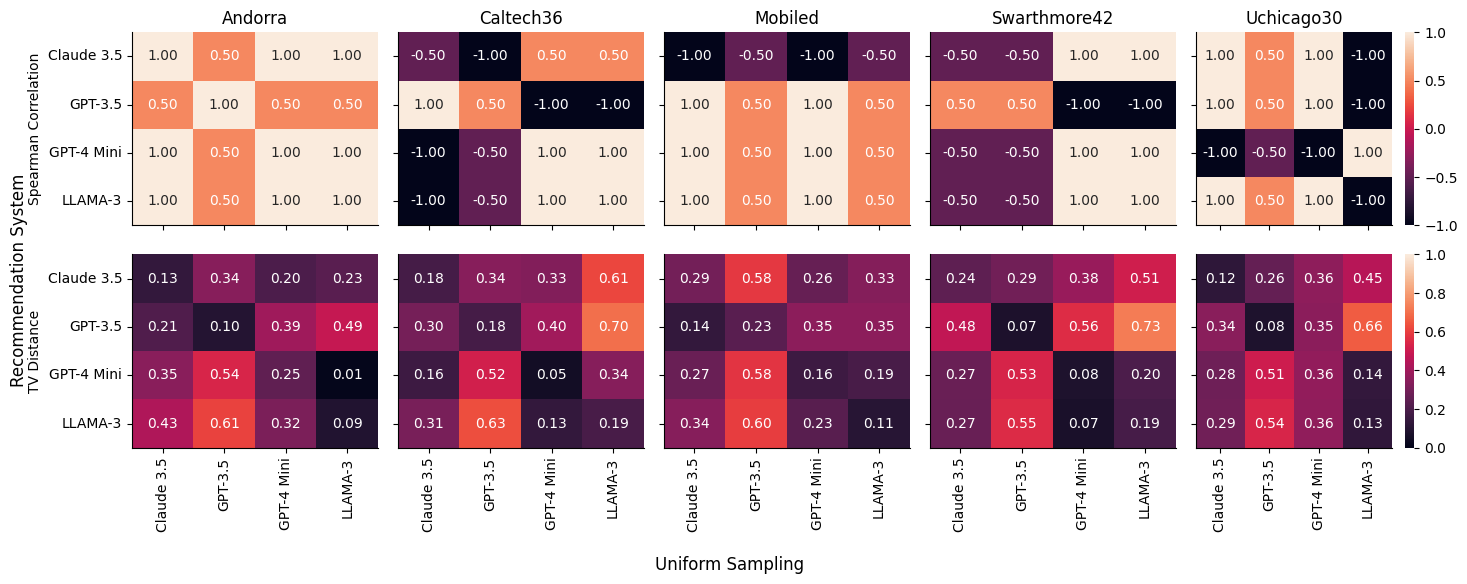

In [2]:
models = ['gpt-3.5-turbo', 'meta/meta-llama-3-70b-instruct', 'gpt-4o-mini', 'claude-3-5-sonnet-20240620']

datasets = ['Caltech36', 'Swarthmore42', 'UChicago30', 'andorra', 'mobiled']
temperatures = [0.5]

num_egonets = -1
egonets_radius = -1
sample_egonets = False
sampling_strategies = ['link_prediction']

table_outfiles1 = []
table_outfiles2 = []

for sampling_strategy in sampling_strategies:
    for model1 in models:
        for model2 in models:
            for name in datasets:
                for i, temperature in enumerate(temperatures, 1):
                    outfile1 = f'outputs/combined_model_{name.lower()}_{i}+{model1.replace("/", "-")}.jsonl'
                    outfile2 = f'outputs/combined_model_{name.lower()}_{i}_+{model2.replace("/", "-")}+{sampling_strategy}.jsonl'

                    table_outfiles1.append(outfile1)
                    table_outfiles2.append(outfile2)


compare_models(table_outfiles1, table_outfiles2, bias=True, log_transform=True, exclude_log=[], heatmap=True, supxlabel='Uniform Sampling', supylabel='Recommendation System', outfile='figures/comparison_between_models_uniform_recsys.png')

In [5]:
df = pd.read_excel('tables/effects_between_models.xlsx')

In [6]:
df

,Name,Model,Label,Feature,AME
0,Caltech36,GPT-3.5,Uniform Sampling,degree,0.18*** (0.00)
1,Caltech36,GPT-3.5,Recommendation System,degree,0.14*** (0.00)
2,Caltech36,GPT-3.5,Uniform Sampling,common_attributes,0.61*** (0.00)
3,Caltech36,GPT-3.5,Recommendation System,common_attributes,0.07*** (0.01)
4,Caltech36,GPT-3.5,Uniform Sampling,common_neighbors,-0.05*** (0.01)
...,...,...,...,...,...
115,Andorra,Claude 3.5,Uniform Sampling,common_attributes,1.45*** (0.01)
116,Andorra,Claude 3.5,Uniform Sampling,common_neighbors,-0.11*** (0.00)
117,Mobiled,Claude 3.5,Uniform Sampling,degree,0.43*** (0.01)
118,Mobiled,Claude 3.5,Uniform Sampling,common_attributes,-1.47*** (0.01)


In [ ]:
print(df.pivot(index=['Name', 'Model'], columns=['Feature', 'Label'], values='AME').to_latex())

'\\begin{tabular}{llllllll}\n\\toprule\n & Feature & \\multicolumn{2}{r}{degree} & \\multicolumn{2}{r}{common_attributes} & \\multicolumn{2}{r}{common_neighbors} \\\\\n & Label & Uniform Sampling & Recommendation System & Uniform Sampling & Recommendation System & Uniform Sampling & Recommendation System \\\\\nName & Model &  &  &  &  &  &  \\\\\n\\midrule\n\\multirow[t]{4}{*}{Andorra} & Claude 3.5 & 0.40*** (0.00) & 0.30*** (0.00) & 1.45*** (0.01) & 1.40*** (0.01) & -0.11*** (0.00) & -0.32*** (0.00) \\\\\n & GPT-3.5 & 0.43*** (0.00) & 0.25*** (0.02) & 0.17*** (0.01) & -0.06*** (0.01) & -0.19*** (0.00) & -0.35*** (0.01) \\\\\n & GPT-4 Mini & 0.31*** (0.00) & 0.08*** (0.00) & 2.00*** (0.03) & 2.54*** (0.01) & -0.05*** (0.01) & -0.45*** (0.00) \\\\\n & LLAMA-3 & 0.19*** (0.00) & 0.33*** (0.00) & 1.92*** (0.01) & 2.24*** (0.01) & -0.02* (0.01) & -0.08*** (0.00) \\\\\n\\cline{1-8}\n\\multirow[t]{4}{*}{Caltech36} & Claude 3.5 & 0.39*** (0.00) & 0.57*** (0.00) & 0.47*** (0.01) & 1.62*** (0.0